## Preamble

In [85]:
## Preamble ##

%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import gamma

from src.model import Model
from src.model_elo import EloModel

def dr(df):
    with pd.option_context('display.max_rows', None):
        display(df)
        
def dc(df):
    with pd.option_context('display.max_columns', None):
        display(df)
        
def drc(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        display(df)
dcr = drc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
## Read in data ##

FRIENDLY_LOSS_WEIGHT = 0.2

results_raw = pd.read_csv("match_results/results.csv", parse_dates=["date"])
results = pd.read_csv("match_results/results_clean.csv", parse_dates=["date"])
results["year"] = results["date"].apply(lambda x: x.year)
confederations = pd.read_csv("reference_data/confederations.csv")
first_confederation = confederations.query("start_year.isna()").set_index("team").confederation
all_teams = pd.read_csv("reference_data/team_universe.csv")
current_fifa_members = all_teams.query("category == 'fifa_member'").team.tolist()
other_teams = all_teams.query("category != 'fifa_member'").team.tolist()
current_teams = all_teams.query("category != 'past_team'").team.tolist()

important_tournaments = [
    "FIFA World Cup",
    "FIFA World Cup qualification",
    "Copa América", # South America
    "Gold Cup", # Noth America
    "UEFA Euro", # Europe
    "UEFA Euro qualification",
    "UEFA Nations League", # Europe 2
    "AFC Asian Cup", # Asia"
    "AFC Asian Cup qualification",
    "African Cup of Nations", # Africa
    "African Cup of Nations qualification",
    # defunct but once important
    "British Home Championship",
    "Nordic Championship",
    "Central European International Cup",
]
big_teams = ['Spain', 'Argentina', 'Brazil', 'Colombia', 'England', 'Portugal', 'France', 'Netherlands', 'Germany', 'Norway', 'Belgium', 'Switzerland', 'Croatia', 'Denmark', 'Ecuador', 'Uruguay', 'Japan', 'Italy', 'Senegal', 'Morocco', 'Austria', 'Canada', 'Greece', 'Turkey', 'Mexico', 'Chile', 'Russia', 'Paraguay', 'Serbia', 'Ukraine', 'South Korea', 'Australia', 'USA', 'Sweden', 'Iran', 'Poland', 'Algeria', 'Venezuela', 'Scotland', 'Czechia']
results["important"] = results.tournament.isin(important_tournaments)
results["importance_class"] = 1
results["importance_class"] = np.where(results["important"], 2, results["importance_class"])
results["importance_class"] = np.where(results["tournament"] == "Friendly", 0, results["importance_class"])

def get_results(team, second_team=None, res=results, start_date=None, end_date = None):
    df_ = res.query(f"home_team == '{team}' or away_team == '{team}'")
    if second_team is not None:
        df_ = df_.query(f"home_team == '{second_team}' or away_team == '{second_team}'")
    if start_date is not None:
        df_ = df_.loc[df_.date >= start_date]
    if end_date is not None:
        df_ = df_.loc[df_.date <= end_date]
    return df_

def calc_loss(res, friendly_loss_weight=FRIENDLY_LOSS_WEIGHT):
    w = np.where(res.tournament == "Friendly", friendly_loss_weight, 1)
    return (
        (res.loss_result * w).sum() / w.sum(),
        (res.loss_score * w).sum() / w.sum()
    )

## Model training, calibration, ratings

In [87]:
# ## Train model ##

model = Model()
res = model.fit(results.iloc[::])

R = res.query("min_games_played >= 10 and date >= '1980'")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important ===")
R = res.query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important t40 ===")
R = res.loc[res.home_team.isin(big_teams) & res.away_team.isin(big_teams)].query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

Loss result:  77.64
Loss score:  278.08

=== important ===
Loss result:  74.94
Loss score:  273.62

=== important t40 ===
Loss result:  89.96
Loss score:  279.88


### Calibration investigations

In [69]:
import numpy as np
from src.model import MAX_GOALS

def mc_probs_for_row(model, row, n_samples=4000, seed=0):
    mu_h = np.array([row.home_mu_attack_pre, row.home_mu_defense_pre])
    mu_a = np.array([row.away_mu_attack_pre, row.away_mu_defense_pre])

    sigma_h = np.array([
        [row.home_sigma_attack_pre, row.home_sigma_ad_pre],
        [row.home_sigma_ad_pre,     row.home_sigma_defense_pre],
    ])
    sigma_a = np.array([
        [row.away_sigma_attack_pre, row.away_sigma_ad_pre],
        [row.away_sigma_ad_pre,     row.away_sigma_defense_pre],
    ])

    out = model.predict_match_from_params(
        mu_h=mu_h,
        mu_a=mu_a,
        sigma_h=sigma_h,
        sigma_a=sigma_a,
        is_neutral=bool(row.neutral),
        mode="mc",
        n_samples=n_samples,
        random_state=seed,
        mu_global=row.mu_global_pre,
        a_hga=row.a_hga_pre,
        d_hga=row.d_hga_pre,
    )

    # W/D/L probability for the actual result
    if row.home_score > row.away_score:
        p_result = out["p_home"]
    elif row.home_score < row.away_score:
        p_result = out["p_away"]
    else:
        p_result = out["p_draw"]

    # Scoreline bucket probability (capped at MAX_GOALS)
    h = min(int(row.home_score), MAX_GOALS)
    a = min(int(row.away_score), MAX_GOALS)
    p_score = float(out["score_matrix"][h, a])

    return p_result, p_score

n_samples = 5000
R = res.query("tournament != 'Friendly'").copy()
R.sort_values("p_score", inplace=True)
for i in range(100):
    idx = R.index[i]
    p_res, p_score = mc_probs_for_row(model, R.loc[idx], n_samples=n_samples, seed=0)
    R.loc[idx, "p_result_mc"] = p_res
    R.loc[idx, "p_score_mc"] = p_score
R.sort_values("p_result", inplace=True)
for i in range(100):
    idx = R.index[i]
    if np.isnan(R.loc[idx, "p_result_mc"]):
        p_res, p_score = mc_probs_for_row(model, R.loc[idx], n_samples=n_samples, seed=0)
        R.loc[idx, "p_result_mc"] = p_res
        R.loc[idx, "p_score_mc"] = p_score

In [83]:
R.query("home_games_played >= 20 and away_games_played >= 20 and p_result_mc <= 0.01").sort_values("p_result_mc", ascending=True).head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,...,min_games_played,p_home,p_draw,p_away,p_result,p_score,loss_result,loss_score,p_result_mc,p_score_mc
3822,1954-08-14,Australia,New Zealand,1,2,Soccer Ashes,Melbourne,Australia,False,NaN,...,36,0.997604,0.001849,0.000547,0.000547,0.000143,6.836862,8.849727,0.003994,0.000879
37192,2015-03-22,Barbados,US Virgin Islands,0,1,FIFA World Cup qualification,Bridgetown,Barbados,False,NaN,...,38,0.986947,0.011026,0.002027,0.002027,0.000930,5.644416,6.980511,0.004104,0.001780
31349,2008-09-10,Switzerland,Luxembourg,1,2,FIFA World Cup qualification,Zürich,Switzerland,False,NaN,...,298,0.968178,0.027555,0.004267,0.004267,0.001107,4.967051,6.805792,0.005702,0.001462
3260,1950-06-29,England,USA,0,1,FIFA World Cup,Belo Horizonte,Brazil,True,NaN,...,37,0.988483,0.008450,0.003067,0.003067,0.000317,5.267708,8.056725,0.006829,0.000687
150,1903-03-21,Scotland,Northern Ireland,0,2,British Home Championship,Glasgow,Scotland,False,NaN,...,62,0.978659,0.015885,0.005455,0.005455,0.000294,4.743426,8.133180,0.009488,0.000570
41190,2019-09-05,Somalia,Zimbabwe,1,0,FIFA World Cup qualification,Djibouti,Djibouti,True,NaN,...,94,0.006116,0.030596,0.963288,0.006116,0.003187,4.639348,5.748811,0.009808,0.004865


In [74]:
R.query("p_score_mc.notna()").sort_values("p_score_mc").head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,shootout_winner,...,min_games_played,p_home,p_draw,p_away,p_result,p_score,loss_result,loss_score,p_result_mc,p_score_mc
36603,2014-07-08,Brazil,Germany,1,7,FIFA World Cup,Belo Horizonte,Brazil,False,NaN,...,885,0.640722,2.175422e-01,1.417362e-01,0.141736,4.730911e-06,1.778414e+00,12.261393,0.150029,0.000010
31145,2008-07-19,Mauritius,Seychelles,0,7,COSAFA Cup qualification,Witbank,South Africa,True,NaN,...,64,0.525964,2.528653e-01,2.211704e-01,0.221170,7.982269e-06,1.373389e+00,11.738288,0.234719,0.000032
24973,2001-06-08,New Zealand,Cook Islands,2,0,FIFA World Cup qualification,North Shore,New Zealand,False,NaN,...,20,1.000000,4.230659e-08,2.398017e-09,1.000000,1.976857e-06,4.069189e-08,13.134003,0.999999,0.000033
29856,2007-04-01,Guam,Northern Mariana Islands,9,0,EAFF Championship,Hagätña,Guam,False,NaN,...,4,0.127491,2.209295e-01,6.515799e-01,0.127491,6.136317e-08,1.874831e+00,16.606456,0.166000,0.000036
11741,1980-02-27,Fiji,New Zealand,4,0,Oceania Nations Cup,Nouméa,New Caledonia,True,NaN,...,38,0.006111,1.804708e-02,9.758418e-01,0.006111,9.691457e-06,4.640078e+00,11.544266,0.011273,0.000037
9884,1975-08-02,Guam,Solomon Islands,1,5,South Pacific Games,Tamuning,Guam,False,NaN,...,1,0.996608,2.875219e-03,5.166788e-04,0.000517,7.924334e-08,6.888772e+00,16.350742,0.009459,0.000040
31868,2009-04-01,Bolivia,Argentina,6,1,FIFA World Cup qualification,La Paz,Bolivia,False,NaN,...,368,0.125524,2.176485e-01,6.568275e-01,0.125524,2.210052e-05,1.888982e+00,10.719909,0.133404,0.000043
18753,1993-09-05,Argentina,Colombia,0,5,FIFA World Cup qualification,Buenos Aires,Argentina,False,NaN,...,230,0.539037,3.131616e-01,1.478011e-01,0.147801,3.463812e-05,1.740275e+00,10.270556,0.153554,0.000056
10864,1977-11-25,Malaysia,Myanmar,9,1,Southeast Asian Games,Kuala Lumpur,Malaysia,False,NaN,...,220,0.421432,2.890061e-01,2.895616e-01,0.421432,2.873573e-05,7.865342e-01,10.457369,0.422878,0.000062
10842,1977-11-13,Romania,Yugoslavia,4,6,FIFA World Cup qualification,Bucharest,Romania,False,NaN,...,253,0.569175,2.501857e-01,1.806390e-01,0.180639,4.286877e-05,1.557651e+00,10.057367,0.191666,0.000062


In [548]:
import numpy as np
import pandas as pd

def diagnostics_by_days_since(res):
    required = {
        "date", "home_team", "away_team",
        "home_score", "away_score",
        "exp_home_score", "exp_away_score",
        "p_home", "p_draw", "p_away",
    }
    missing = required - set(res.columns)
    if missing:
        raise ValueError(f"res missing columns: {sorted(missing)}")

    df = res.copy()
    df["date"] = pd.to_datetime(df["date"])
    df = df.sort_values("date")

    last_played = {}
    rows = []
    home_days = []
    away_days = []

    for row in df.itertuples(index=False):
        date = row.date

        d_home = None if row.home_team not in last_played else (date - last_played[row.home_team]).days
        d_away = None if row.away_team not in last_played else (date - last_played[row.away_team]).days

        home_days.append(d_home)
        away_days.append(d_away)

        rows.append({
            "team": row.home_team,
            "days_since": d_home,
            "score": row.home_score,
            "exp_score": row.exp_home_score,
            "points": 1.0 if row.home_score > row.away_score else (0.5 if row.home_score == row.away_score else 0.0),
            "exp_points": row.p_home + 0.5 * row.p_draw,
        })
        rows.append({
            "team": row.away_team,
            "days_since": d_away,
            "score": row.away_score,
            "exp_score": row.exp_away_score,
            "points": 1.0 if row.away_score > row.home_score else (0.5 if row.away_score == row.home_score else 0.0),
            "exp_points": row.p_away + 0.5 * row.p_draw,
        })

        last_played[row.home_team] = date
        last_played[row.away_team] = date

    df["home_days_since"] = home_days
    df["away_days_since"] = away_days
    df["max_days_since"] = np.maximum(df["home_days_since"], df["away_days_since"])

    out = pd.DataFrame(rows)
    out = out.dropna(subset=["days_since"])
    out["days_since"] = out["days_since"].astype(int)

    summary = out.groupby("days_since", as_index=True).agg(
        n_games=("score", "size"),
        score=("score", "sum"),
        exp_score=("exp_score", "sum"),
        points=("points", "sum"),
        exp_points=("exp_points", "sum"),
    )
    return summary, df

In [268]:
# ## Train model ##

model0 = Model()
res0 = model0.fit(results)

R = res0.query("min_games_played >= 10 and date >= '1980'")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important ===")
R = res0.query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important t40 ===")
R = res0.loc[res0.home_team.isin(big_teams) & res0.away_team.isin(big_teams)].query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

Loss result:  77.50
Loss score:  277.66

=== important ===
Loss result:  75.19
Loss score:  273.26

=== important t40 ===
Loss result:  88.83
Loss score:  276.65


In [425]:
# ## Train model ##

model1 = Model(
    # importance_class_weights={0: 0.1, 1: 0.2, 2: 1.0},
    importance_class_weights={0: 0.4, 1: 0.6, 2: 1.0},

    # importance_class_weights={0: 0.4, 1: 0.4, 2: 1.0},
    # censor_big_wins=True,
    # censor_big_win_margin=5
)
res1 = model1.fit(results)

R = res1.query("min_games_played >= 10 and date >= '1980'")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important ===")
R = res1.query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important t40 ===")
R = res1.loc[res1.home_team.isin(big_teams) & res1.away_team.isin(big_teams)].query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

Loss result:  77.67
Loss score:  278.18

=== important ===
Loss result:  75.25
Loss score:  273.47

=== important t40 ===
Loss result:  89.01
Loss score:  276.93


In [426]:
# ## Train model ##

model2 = Model(
    importance_class_weights={0: 0.4, 1: 0.7, 2: 1.0},
    # censor_big_wins=True,
    # censor_big_win_margin=5
)
res2 = model2.fit(results)

R = res2.query("min_games_played >= 10 and date >= '1980'")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important ===")
R = res2.query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

print("\n=== important t40 ===")
R = res2.loc[res2.home_team.isin(big_teams) & res2.away_team.isin(big_teams)].query("min_games_played >= 10 and date >= '1980' and importance_class == 2")
loss_result, loss_score = calc_loss(R)
print(f"Loss result: {loss_result*100:6.2f}")
print(f"Loss score:  {loss_score*100 :6.2f}")

Loss result:  78.45
Loss score:  280.15

=== important ===
Loss result:  75.69
Loss score:  274.59

=== important t40 ===
Loss result:  89.59
Loss score:  278.10


In [479]:
res0.query("importance_class == 1").tournament.value_counts().head(20)

tournament
UEFA Euro qualification            2824
UEFA Nations League                 658
CFU Caribbean Cup qualification     583
Merdeka Tournament                  576
CECAFA Cup                          502
Gulf Cup                            410
CONCACAF Nations League             402
Asian Games                         365
COSAFA Cup                          354
AFF Championship                    291
CFU Caribbean Cup                   251
King's Cup                          248
Amílcar Cabral Cup                  235
Southeast Asian Games               182
Arab Cup                            175
CONCACAF Championship               169
UNCAF Cup                           164
SAFF Cup                            162
South Pacific Games                 157
Korea Cup                           155
Name: count, dtype: int64

In [444]:
import numpy as np
import pandas as pd

def team_summary(res):
    required = {
        "home_team", "away_team",
        "home_score", "away_score",
        "exp_home_score", "exp_away_score",
        "p_home", "p_draw", "p_away",
        "loss_result", "loss_score",
    }
    missing = required - set(res.columns)
    if missing:
        raise ValueError(f"res missing columns: {sorted(missing)}")

    home = res[[
        "home_team", "home_score", "away_score",
        "exp_home_score", "p_home", "p_draw",
        "loss_result", "loss_score",
    ]].copy()
    home.rename(columns={
        "home_team": "team",
        "home_score": "score",
        "exp_home_score": "exp_score",
    }, inplace=True)
    home["points"] = np.where(
        home["score"] > home["away_score"], 1.0,
        np.where(home["score"] == home["away_score"], 0.5, 0.0)
    )
    home["exp_points"] = home["p_home"] + 0.5 * home["p_draw"]
    home["num_games"] = 1

    away = res[[
        "away_team", "home_score", "away_score",
        "exp_away_score", "p_away", "p_draw",
        "loss_result", "loss_score",
    ]].copy()
    away.rename(columns={
        "away_team": "team",
        "away_score": "score",
        "exp_away_score": "exp_score",
    }, inplace=True)
    away["points"] = np.where(
        away["score"] > away["home_score"], 1.0,
        np.where(away["score"] == away["home_score"], 0.5, 0.0)
    )
    away["exp_points"] = away["p_away"] + 0.5 * away["p_draw"]
    away["num_games"] = 1

    out = pd.concat([home, away], ignore_index=True)
    out = out.groupby("team", as_index=False).sum()
    out["outperformance_score"] = out["score"] - out["exp_score"]
    out["outperformance_points"] = out["points"] - out["exp_points"]
    return out.set_index("team").sort_values("score", ascending=False)

R0 = res0.query("year >= 1980 and importance_class == 2")
R1 = res1.query("year >= 1980 and importance_class == 2")
R2 = res2.query("year >= 1980 and importance_class == 2")
summary0 = team_summary(R0)
summary1 = team_summary(R1)
summary2 = team_summary(R2)

In [523]:
summary = team_summary(res.query("year >= 1980 and importance_class == 2"))
summary.sort_values("outperformance_points")

,score,away_score,exp_score,p_home,p_draw,loss_result,loss_score,points,exp_points,num_games,home_score,p_away,outperformance_score,outperformance_points
team,,,,,,,,,,,,,,
Malta,111,256.0,124.042264,16.523539,34.990737,106.112493,600.751100,29.5,39.849955,229,349.0,5.831047,-13.042264,-10.349955
Brazil,565,106.0,611.929062,133.036373,60.299496,232.730628,818.809200,213.0,222.830837,293,103.0,59.644716,-46.929062,-9.830837
Belarus,160,114.0,183.921843,33.043861,38.878042,135.905324,476.662640,60.0,69.675275,173,161.0,17.192394,-23.921843,-9.675275
Chile,334,126.0,332.556353,61.670640,62.394369,204.618698,709.491203,117.5,126.500446,246,194.0,33.632622,1.443647,-9.000446
Thailand,242,101.0,260.242128,42.195401,34.459122,119.677464,489.200726,73.5,82.180101,168,166.0,22.755139,-18.242128,-8.680101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Portugal,615,104.0,584.019452,102.645636,69.024400,238.290284,865.407662,219.5,209.293177,310,146.0,72.135342,30.980548,10.206823
Greece,339,123.0,353.960858,68.715112,65.179659,223.785731,702.475496,152.5,140.893093,262,150.0,39.588152,-14.960858,11.606907
Cameroon,449,108.0,446.873120,96.829188,76.111831,246.049488,798.435695,198.5,185.107712,297,138.0,50.222609,2.126880,13.392288


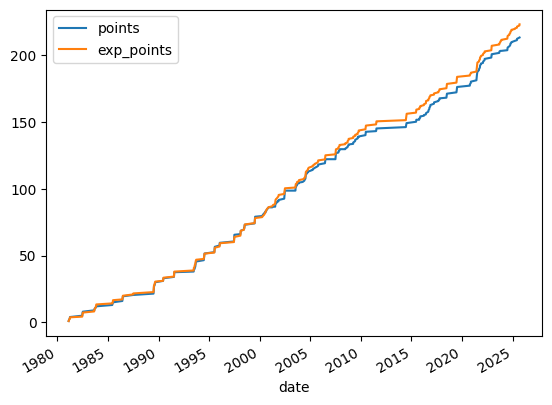

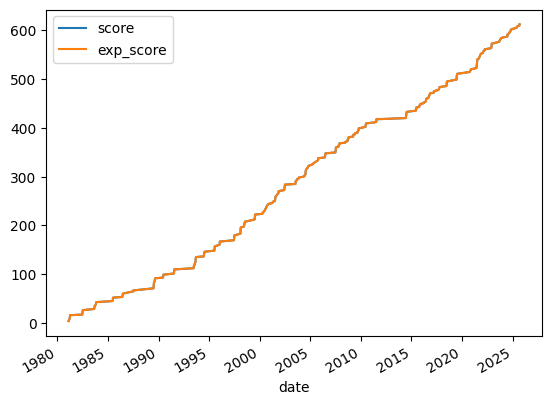

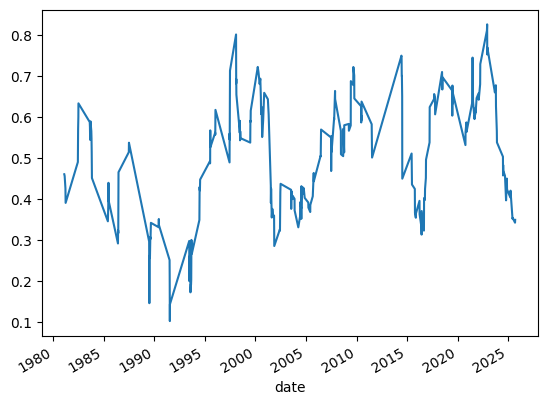

In [536]:
team = "Brazil"
R = get_results(team, res=res.query("year >= 1980 and importance_class == 2")).copy()
R["points"] = np.where(
    R.home_team == team,
    np.where(R.home_score > R.away_score, 1, np.where(R.home_score == R.away_score, 1/2, 0)),
    np.where(R.home_score < R.away_score, 1, np.where(R.home_score == R.away_score, 1/2, 0))
)
R["exp_points"] = np.where(
    R.home_team == team,
    R.p_home + 1/2 * R.p_draw,
    R.p_away + 1/2 * R.p_draw
)
R["score"] = np.where(R.home_team == team, R.exp_home_score, R.exp_away_score)
R["exp_score"] = np.where(R.home_team == team, R.exp_home_score, R.exp_away_score)
R["quality"] = np.where(
    R.home_team == team,
    R.home_mu_attack_pre+R.home_mu_defense_pre,
    R.away_mu_attack_pre+R.away_mu_defense_pre
)
R.set_index("date")[["points", "exp_points"]].cumsum().plot(); plt.show()
R.set_index("date")[["score", "exp_score"]].cumsum().plot(); plt.show()
R.set_index("date")["quality"].plot(); plt.show()

In [491]:
team_summary(res.query("year >= 2000 and importance_class == 2")).loc["France"]

score                    202.000000
away_score                43.000000
exp_score                210.536203
p_home                    39.562071
p_draw                    29.595579
loss_result              104.451808
loss_score               331.146184
points                    86.500000
exp_points                82.870856
num_games                122.000000
home_score                54.000000
p_away                    28.510996
outperformance_score      -8.536203
outperformance_points      3.629144
Name: France, dtype: float64

In [428]:
summary2.abs().mean()

score                    167.838710
away_score                64.433180
exp_score                171.091030
p_home                    30.364808
p_draw                    27.756427
loss_result               93.557514
loss_score               339.650949
points                    61.847926
exp_points                61.847926
num_games                123.695853
home_score               103.405530
p_away                    17.604905
outperformance_score       7.438191
outperformance_points      2.761200
dtype: float64

In [429]:
summary1.abs().mean()

score                    167.838710
away_score                64.433180
exp_score                170.274012
p_home                    30.111411
p_draw                    27.946825
loss_result               93.001109
loss_score               338.248742
points                    61.847926
exp_points                61.847926
num_games                123.695853
home_score               103.405530
p_away                    17.763103
outperformance_score       8.361429
outperformance_points      2.875963
dtype: float64

In [430]:
summary0.abs().mean()

score                    167.838710
away_score                64.433180
exp_score                169.871847
p_home                    29.911302
p_draw                    28.036148
loss_result               92.920320
loss_score               337.979705
points                    61.847926
exp_points                61.847926
num_games                123.695853
home_score               103.405530
p_away                    17.918550
outperformance_score       9.720015
outperformance_points      3.109557
dtype: float64

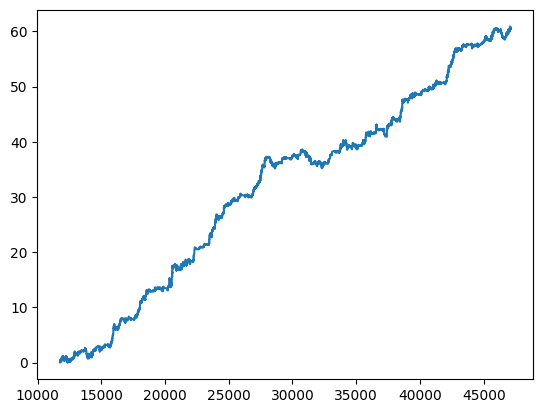

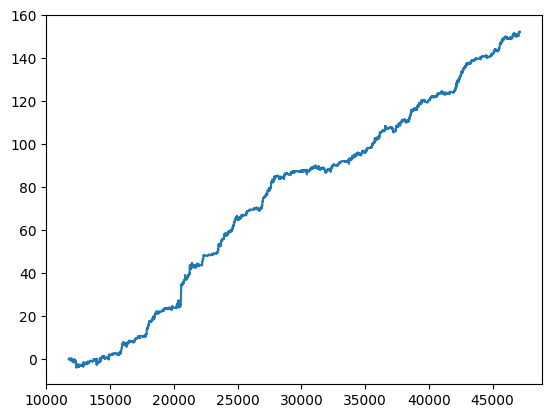

In [461]:
Rold = R1
Rnew = R2
(Rnew.loss_result.cumsum() - Rold.loss_result.cumsum()).plot(); plt.show()
(Rnew.loss_score.cumsum() - Rold.loss_score.cumsum()).plot(); plt.show()

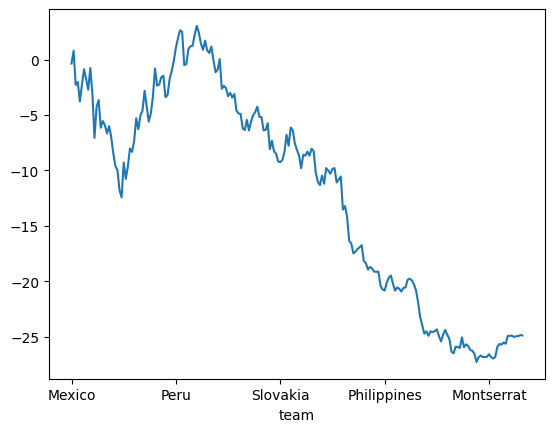

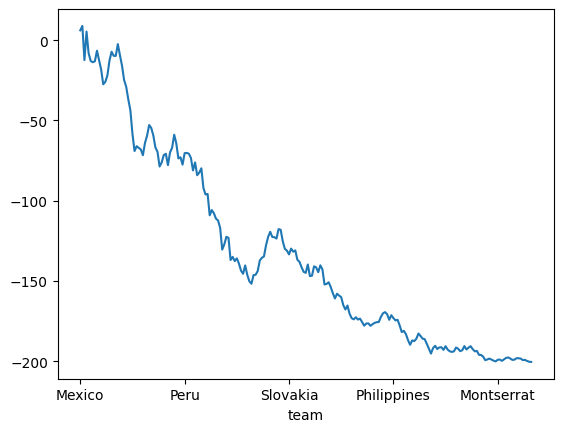

In [460]:
sold = summary1
snew = summary2
(snew.outperformance_points.abs() - sold.outperformance_points.abs()).cumsum().plot(); plt.show()
(snew.outperformance_score.abs() - sold.outperformance_score.abs()).cumsum().plot(); plt.show()

In [233]:
"""
Current H0

Loss result:  77.50
Loss score:  279.08

=== important ===
Loss result:  75.18
Loss score:  274.62

=== important t40 ===
Loss result:  88.81
Loss score:  276.65

with importance weights...

Loss result:  77.82
Loss score:  279.89

=== important ===
Loss result:  75.41
Loss score:  275.19

=== important t40 ===
Loss result:  89.20
Loss score:  277.30
"""

'\nCurrent H0\n\nLoss result:  77.50\nLoss score:  279.08\n\n=== important ===\nLoss result:  75.18\nLoss score:  274.62\n\n=== important t40 ===\nLoss result:  88.81\nLoss score:  276.65\n\nwith importance weights...\n\nLoss result:  77.82\nLoss score:  279.89\n\n=== important ===\nLoss result:  75.41\nLoss score:  275.19\n\n=== important t40 ===\nLoss result:  89.20\nLoss score:  277.30\n'

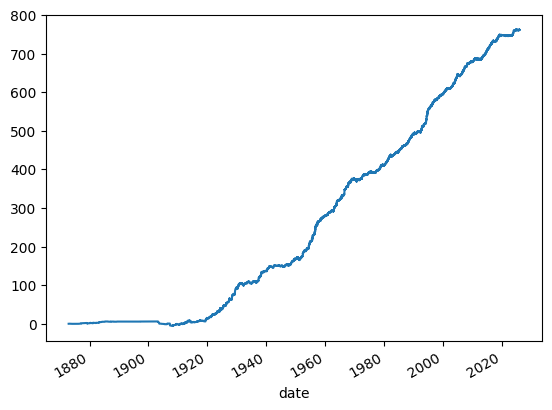

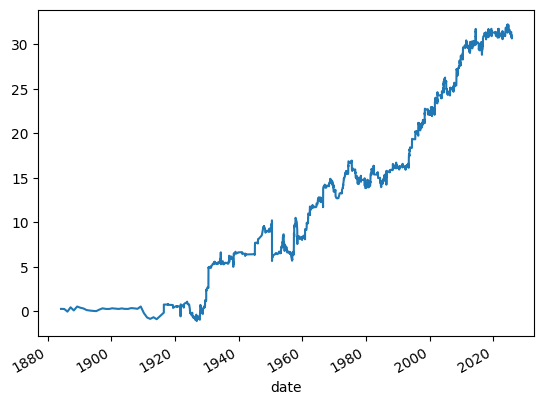

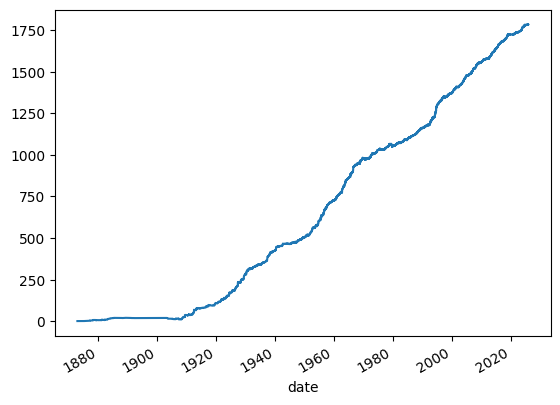

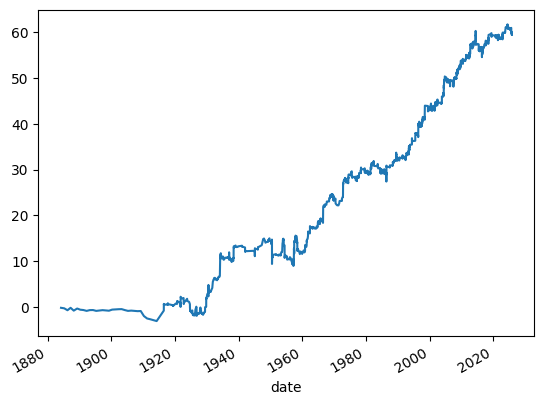

In [249]:
R0 = res0.loc[res0.home_team.isin(big_teams) & res0.away_team.isin(big_teams)].query("importance_class==2")
R1 = res.loc[res.home_team.isin(big_teams) & res.away_team.isin(big_teams)].query("importance_class==2")
metric = "loss_result"
(res.set_index("date")[metric].cumsum() - res0.set_index("date")[metric].cumsum()).plot()
plt.show()
(R1.set_index("date")[metric].cumsum() - R0.set_index("date")[metric].cumsum()).plot()
plt.show()
metric = "loss_score"
(res.set_index("date")[metric].cumsum() - res0.set_index("date")[metric].cumsum()).plot()
plt.show()
(R1.set_index("date")[metric].cumsum() - R0.set_index("date")[metric].cumsum()).plot()
plt.show()

## Param histories and rankings

In [88]:
## Export metrics and define qualities ##

df_state = model.export_state_df()
df_mu = model.export_mu_df()
df_hga = model.export_hga_df()
df_state["quality"] = df_state["mu_attack"] + df_state["mu_defense"]
df_state["quality_low"] = df_state["quality"] - 2 * np.sqrt(df_state["sigma_attack"] + df_state["sigma_defense"] + 2 * df_state["sigma_ad"])
df_state["mu_attack_low"] = df_state["mu_attack"] - 2 * np.sqrt(df_state["sigma_attack"])
df_state["mu_defense_low"] = df_state["mu_defense"] - 2 * np.sqrt(df_state["sigma_defense"])
df_state["year"] = df_state.date.apply(lambda x: x.year)

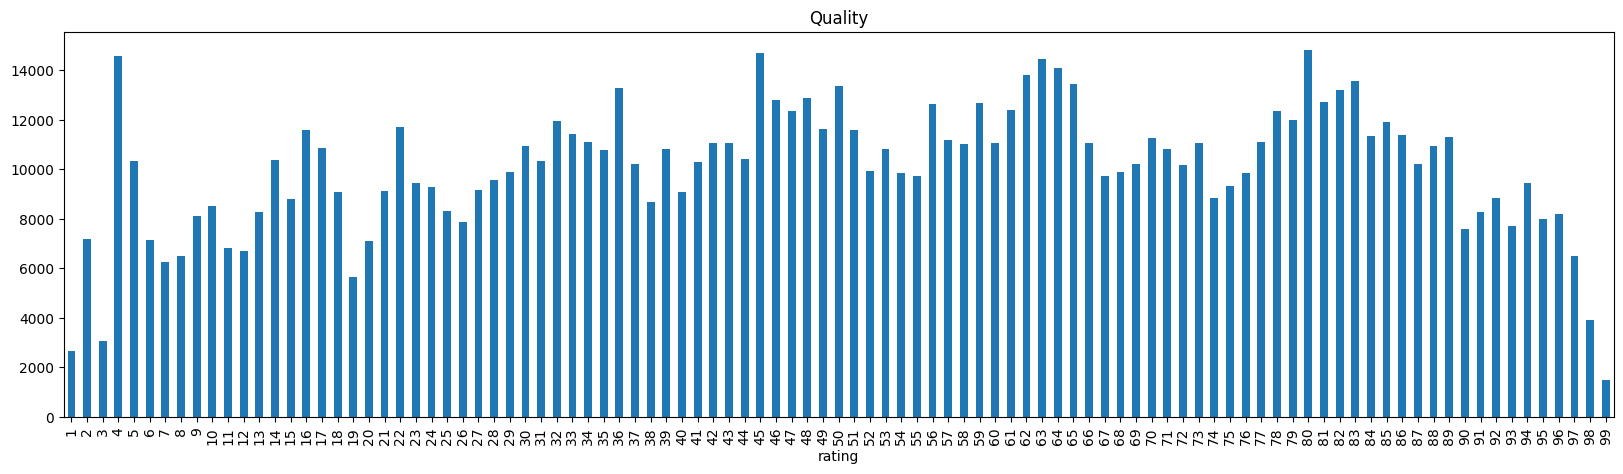

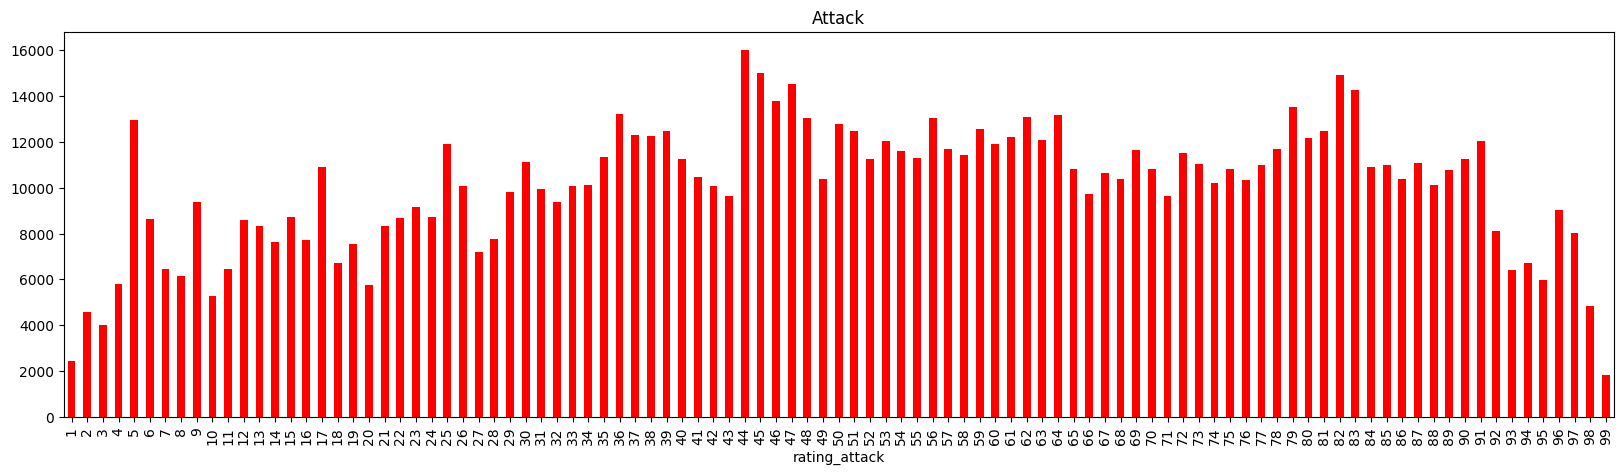

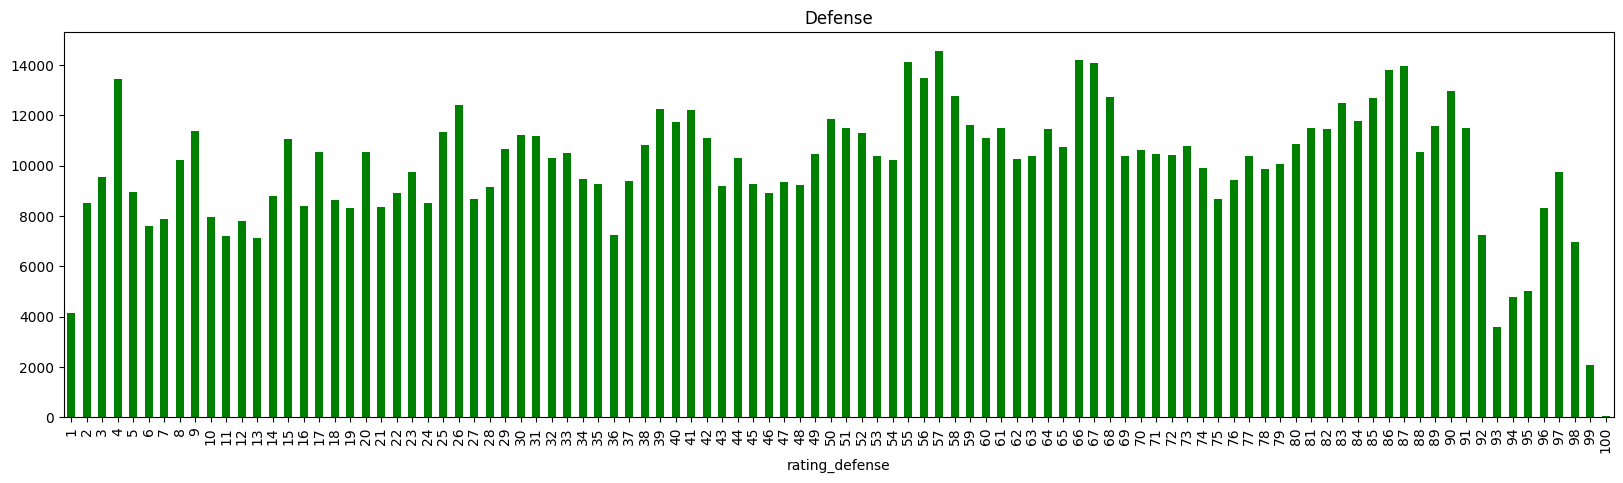

In [89]:
## convert from params to ratings ##

a = 6.0 # larger = more teams get to be high 90s
b = 2.1 # larger = teams drawn away from zero
c = 1.0 # anything above this will be treated identically, so teams should not get near it
cdf_func = lambda x: 1.0 - gamma.cdf(c - x, a=a, scale=b/a)
rating_func = lambda x: 100 * cdf_func(x)
df_state["rating_attack"] = rating_func(df_state["mu_attack"])
df_state["rating_defense"] = rating_func(df_state["mu_defense"])
df_state["rating"] = rating_func(df_state["quality"] / 2)
df_state.query("year >= 2000")["rating"].round().astype(int).value_counts().sort_index().plot.bar(title="Quality", figsize=(20,5)); plt.show()
df_state.query("year >= 2000")["rating_attack"].round().astype(int).value_counts().sort_index().plot.bar(title="Attack", color="red", figsize=(20,5)); plt.show()
df_state.query("year >= 2000")["rating_defense"].round().astype(int).value_counts().sort_index().plot.bar(title="Defense", color="green", figsize=(20,5)); plt.show()

In [90]:
## produce team histories, ratings, and rankings ##

df_history = df_state.set_index(["date", "team"]).unstack().ffill()

for team in all_teams.query("category == 'past_team'").team:
    last_date = get_results(team).date.max().date()
    df_history.loc[
        df_history.index > last_date,
        [c for c in df_history.columns if c[1] == team]
    ] = np.nan

current_rating = df_history.rating[current_teams].iloc[-1].sort_values(ascending=False).round(2)
current_rating.name = "rating"
elo_ratings = pd.read_csv("reference_data/alt_rankings/elo_ratings_20260104.csv")
fifa_ratings = pd.read_csv("reference_data/alt_rankings/fifa_rankings_20251218.csv")

# all_ratings = df_history[["rating", "rating_attack", "rating_defense", "quality", "mu_attack", "mu_defense"]].iloc[-1].unstack().T
all_ratings = df_history.iloc[-1].unstack().T
all_rankings = current_rating.to_frame().reset_index().rename(columns={"rating": "model"})
all_rankings = all_rankings.merge(elo_ratings, on="team")
all_rankings = all_rankings.merge(fifa_ratings[["team", "fifa_points"]].rename(columns={"fifa_points": "fifa"}), on="team")
all_rankings.set_index("team", inplace=True)
C = all_rankings.columns.tolist()
for attr in C:
    all_rankings[f"rank_{attr}"] = (
        all_rankings[attr]
        .rank(method="min", ascending=False, na_option="bottom")
        .astype("Int64")
    )
for attr in C:
    if c == "model":
        continue
    all_rankings[f"rank_diff_{attr}"] = all_rankings["rank_model"] - all_rankings[f"rank_{attr}"]
all_rankings.head(10)

,model,elo,fifa,rank_model,rank_elo,rank_fifa,rank_diff_model,rank_diff_elo,rank_diff_fifa
team,,,,,,,,,
Spain,98.08,2171,1877.18,1,1,1,0,0,0
Argentina,97.82,2113,1873.33,2,2,2,0,0,0
England,96.63,2042,1834.12,3,4,4,0,-1,-1
Brazil,96.23,1979,1760.46,4,6,5,0,-2,-1
Portugal,95.61,1976,1760.38,5,7,6,0,-2,-1
France,95.51,2062,1870.00,6,3,3,0,3,3
Colombia,95.46,1998,1701.30,7,5,13,0,2,-6
Netherlands,93.03,1959,1756.27,8,8,7,0,0,1
Germany,92.80,1910,1724.15,9,12,9,0,-3,0


In [96]:
all_ratings

,mu_attack,mu_defense,sigma_attack,sigma_defense,sigma_ad,mu_global,quality,quality_low,mu_attack_low,mu_defense_low,year,rating_attack,rating_defense,rating
team,,,,,,,,,,,,,,
Afghanistan,-1.797893,-1.669434,0.027242,0.021571,0.011358,0.281432,-3.467328,-4.002225,-2.127995,-1.963178,2025.0,19.178807,22.784362,20.922108
Albania,-0.736018,-0.430532,0.018310,0.017923,0.008537,0.281432,-1.166550,-1.628318,-1.006648,-0.698283,2025.0,62.296980,77.135193,69.888632
Algeria,-0.375171,-0.478817,0.013424,0.020403,0.007780,0.281432,-0.853988,-1.298454,-0.606893,-0.764494,2025.0,79.611718,74.901884,77.296285
American Samoa,-3.443619,-3.605107,0.065669,0.028788,0.018334,0.281432,-7.048726,-7.772950,-3.956138,-3.944450,2025.0,1.307027,0.968453,1.125788
Andorra,-1.843788,-1.125054,0.029554,0.014817,0.008862,0.281432,-2.968842,-3.467218,-2.187612,-1.368508,2025.0,18.004260,43.425141,28.832473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Wales,-0.460771,-0.350392,0.016038,0.018546,0.008175,0.281432,-0.811162,-1.262535,-0.714055,-0.622757,2025.0,75.743852,80.687224,78.263315
Yemen,-1.418890,-1.345066,0.021584,0.020240,0.009836,0.281432,-2.763956,-3.259928,-1.712719,-1.629602,2025.0,31.220432,34.062343,32.621513
Yugoslavia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Flat track bullies

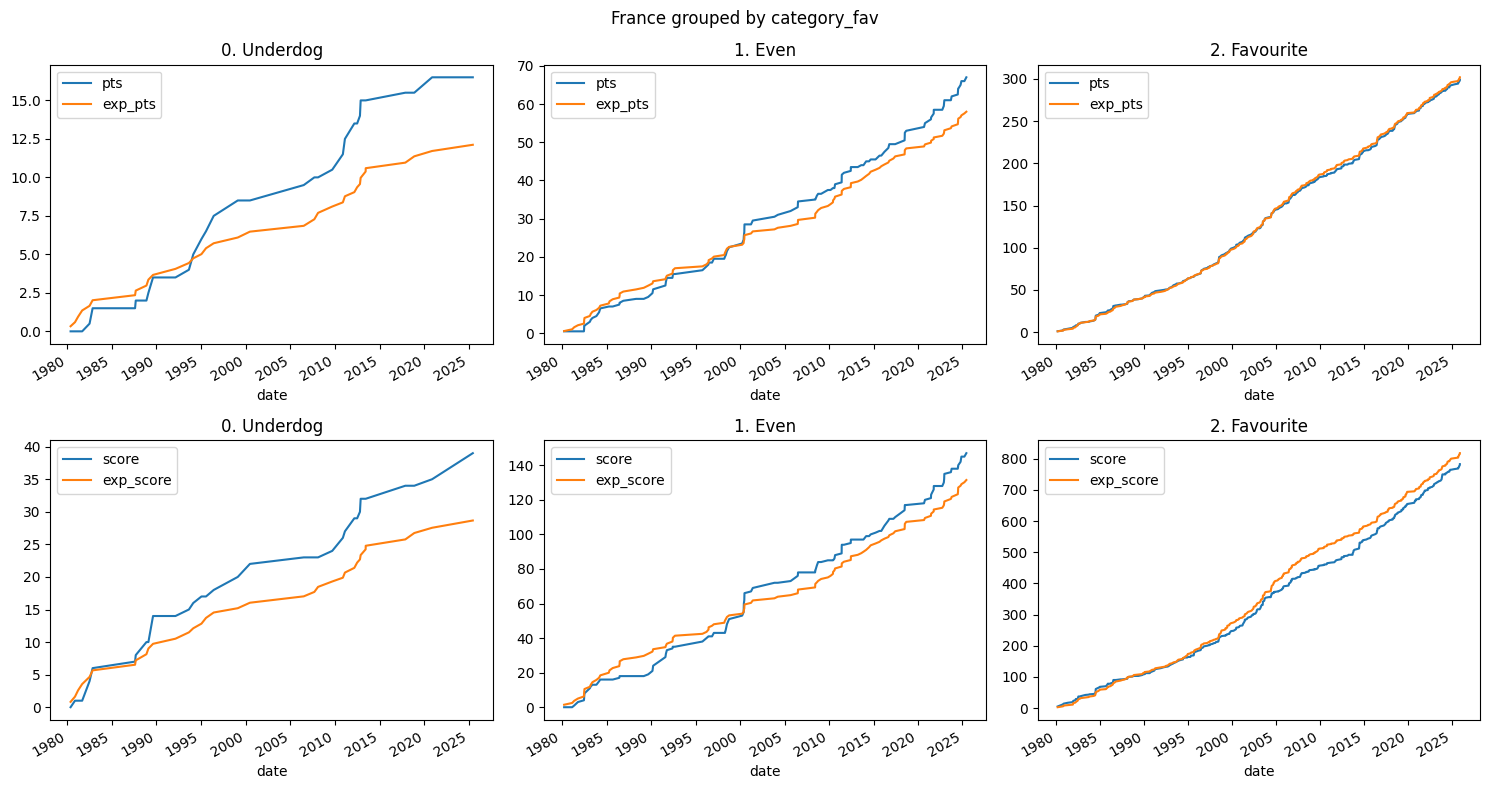

In [64]:
team = "France"
res_ = get_results(team, res=res.query("year >= 1980")).copy()
is_home = (res_["home_team"] == team)
is_home_win = (res_["home_score"] > res_["away_score"]).astype(int)
is_away_win = (res_["home_score"] < res_["away_score"]).astype(int)
is_draw = (res_["home_score"] == res_["away_score"]).astype(int)
res_["eta_diff"] = (res_["eta_home_pre"] - res_["eta_away_pre"]) * np.where(is_home, 1, -1)
res_["score"] = np.where(is_home, res_.home_score, res_.away_score)
res_["exp_score"] = np.where(is_home, res_.exp_home_score, res_.exp_away_score)
res_["opp_score"] = np.where(is_home, res_.away_score, res_.home_score)
res_["exp_opp_score"] = np.where(is_home, res_.exp_away_score, res_.exp_home_score)
res_["pts"] = np.where(is_home, is_home_win, is_away_win) + 0.5 * is_draw
res_["exp_pts"] = np.where(is_home, res_.p_home, res_.p_away) + 0.5 * res_.p_draw
res_["category_fav"] = "1. Even"
res_["category_fav"] = np.where(res_.eta_diff < -0.3, "0. Underdog", res_["category_fav"])
res_["category_fav"] = np.where(res_.eta_diff > 0.3, "2. Favourite", res_["category_fav"])
res_["category_imp"] = res_["important"].astype(str)
# res_["category_imp"] = "Unimportant"
# res_["category_imp"] = np.where(
#     res_.tournament.str.lower().str.contains("world cup") 
#     | res_.tournament.str.lower().str.contains("euro")
#     | res_.tournament.str.lower().str.contains("copa"),
#     "Important",
#     res_["category_imp"]
# )
# res_["category_imp"] = np.where(res_.tournament.str.lower().str.contains("friendly"), "Friendly", res_["category_imp"])

category = "category_fav"
fig, axs = plt.subplots(2, 3, figsize=(15,8))
for i, cat in enumerate(sorted(res_[category].unique())):
    res_.query(f"{category} == '{cat}'").set_index("date")[["pts", "exp_pts"]].cumsum().plot(ax=axs[0,i], title=cat)
    res_.query(f"{category} == '{cat}'").set_index("date")[["score", "exp_score"]].cumsum().plot(ax=axs[1,i], title=cat)
plt.suptitle(f"{team} grouped by {category}")
plt.tight_layout()
plt.show()

## Simulations

In [91]:
from src.tournament import WorldCup2026

T = []
N = 10000
for i in range(N):
    t = WorldCup2026()
    t.simulate(model, random_state=i, record_params=True)
    T.append(t)
    print(f"\r{i+1 :5} / {N}", end="")

champions = pd.Series([t.champion for t in T])

10000 / 10000

In [ ]:
wc_teams = sorted(set(t.results_frame().home_team.tolist() + t.results_frame().away_team.tolist()))

elim = [t.stage_of_elimination() for t in T]
stages = set(elim[0].values())

stages = sorted(set(elim[0].values()))

stage_counts = pd.DataFrame(
    index=wc_teams,
    columns=stages,
    data=0
)
for e in elim:
    for team, stage in e.items():
        stage_counts.loc[team, stage] += 1

ratings_with_wins = all_ratings.loc[wc_teams].sort_values("quality", ascending=False).join(stage_counts)
ratings_with_wins["odds_champion"] = (N / ratings_with_wins["8. Champion"]).round(2)
ratings_with_wins = ratings_with_wins.join(
    pd.read_csv("reference_data/betfair.csv").replace({"Republic of Ireland": "Ireland", "Bosnia": "Bosnia and Herzegovina"}).set_index("team").rename(columns={"odds": "odds_betfair"})
)
ratings_with_wins["kelly"] = (100 * np.maximum(0, 1 / ratings_with_wins["odds_champion"] - (1 - 1 / ratings_with_wins["odds_champion"]) / (1 + 0.94 * (ratings_with_wins["odds_betfair"] - 1) - 1))).round(1)

In [ ]:
dcr(ratings_with_wins.iloc[:,-15:].query("kelly > 0.2").sort_values("kelly", ascending=False))
dcr(ratings_with_wins.iloc[:,-15:])

,rating_attack,rating_defense,rating,0. Qualifying,1. Group,2. Round of 32,3. Round of 16,4. Quarterfinal,5. Fourth place,6. Third place,7. Final,8. Champion,odds_champion,odds_betfair,kelly
team,,,,,,,,,,,,,,,
Argentina,96.360506,98.814888,97.814649,0,12,350,115,155,39,87,76,166,6.02,9.8,6.5
Colombia,92.417040,97.601463,95.463143,0,45,307,259,171,37,58,59,64,15.62,60.0,4.7
Uruguay,89.050421,92.350216,90.780230,0,71,479,198,129,39,27,25,32,31.25,110.0,2.3
Switzerland,90.946564,89.578420,90.275323,0,51,354,317,166,37,35,25,15,66.67,140.0,0.7
Ecuador,86.884402,91.859466,89.525953,0,41,429,299,110,40,25,38,18,55.56,95.0,0.7
Croatia,89.025187,89.494086,89.260960,0,103,488,218,109,25,21,22,14,71.43,130.0,0.6
Spain,98.471617,97.828613,98.169362,0,3,222,221,118,44,94,120,178,5.62,6.0,0.3
Australia,77.620130,83.859761,80.837328,0,330,367,201,75,11,7,4,5,200.00,660.0,0.3


,rating_attack,rating_defense,rating,0. Qualifying,1. Group,2. Round of 32,3. Round of 16,4. Quarterfinal,5. Fourth place,6. Third place,7. Final,8. Champion,odds_champion,odds_betfair,kelly
team,,,,,,,,,,,,,,,
Spain,98.471617,97.828613,98.169362,0,3,222,221,118,44,94,120,178,5.62,6.0,0.3
Argentina,96.360506,98.814888,97.814649,0,12,350,115,155,39,87,76,166,6.02,9.8,6.5
England,94.768650,97.936644,96.586815,0,20,283,229,192,45,74,76,81,12.35,7.0,0.0
Brazil,95.402447,96.945781,96.224279,0,23,266,214,167,65,83,78,104,9.62,9.6,0.0
Colombia,92.417040,97.601463,95.463143,0,45,307,259,171,37,58,59,64,15.62,60.0,4.7
France,94.246614,96.304734,95.346081,0,48,277,231,173,43,82,75,71,14.08,9.2,0.0
Portugal,95.678245,94.729543,95.218424,0,25,264,289,174,51,59,67,71,14.08,13.5,0.0
Netherlands,95.324737,90.889500,93.321354,0,93,399,172,138,54,59,46,39,25.64,28.0,0.1
Germany,96.869599,86.427034,92.706983,0,13,343,323,138,54,60,40,29,34.48,15.0,0.0


## One-off gambling

In [25]:
r = t.results_frame()
playoffs = r.loc[r.stage.str.contains("Playoff")]
playoff_teams = sorted(set(playoffs.home_team.tolist() + playoffs.away_team.tolist()))

In [33]:
rq = r.query("stage.str.contains('semi')")
r1 = r.query("stage == 'Group'").sort_values("date").groupby("group").head(2)
r1 = r1.loc[
    ~r1.home_team.isin(playoff_teams)
    & ~r1.away_team.isin(playoff_teams)
]
r_confirmed = pd.concat([rq, r1])
for match in r_confirmed.itertuples():
    home = match.home_team
    away = match.away_team
    is_neutral = match.is_neutral
    pred = (model.predict_match(home, away, is_neutral=is_neutral, mode="mc", n_samples=10000))
    suff = " [QUALIFYING]" if match.stage != "Group" else ""
    print(f'{1/pred["p_home"]:6.2f} {home:>25} {1/pred["p_draw"]:6.2f} {away:>25} {1/pred["p_away"]:6.2f}{suff}')

 13.31             New Caledonia   6.77                   Jamaica   1.29 [QUALIFYING]
  1.54                   Bolivia   5.00                  Suriname   6.60 [QUALIFYING]
  1.68                     Wales   4.05    Bosnia and Herzegovina   6.38 [QUALIFYING]
  1.41                     Italy   4.85          Northern Ireland  11.70 [QUALIFYING]
  2.59                   Ukraine   3.78                    Sweden   2.85 [QUALIFYING]
  1.77                    Poland   3.73                   Albania   6.03 [QUALIFYING]
  1.98                  Slovakia   3.71                    Kosovo   4.44 [QUALIFYING]
  1.54                    Turkey   4.70                   Romania   7.15 [QUALIFYING]
  1.90                   Czechia   3.57                   Ireland   5.18 [QUALIFYING]
  1.25                   Denmark   7.07           North Macedonia  17.50 [QUALIFYING]
  1.61                    Mexico   3.89              South Africa   8.17
  2.25                       USA   3.41                  Paraguay  